In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import plotly.express as px
import plotly.graph_objects as go

In [39]:
#Carregar arquivo de tempo x distância
data = pd.read_excel(r'.\xls\tempodist.xls', sheet_name='Plan3')
data

,Tempo (Y),Distância (X)
0,85,45
1,90,46
2,21,16
3,40,32
4,50,39
5,25,18
6,10,7
7,55,41
8,35,28
9,30,24


In [40]:
#Estatística univariadas
data[['Tempo (Y)', 'Distância (X)']].describe()


,Tempo (Y),Distância (X)
count,10.0000,10.00000
mean,44.1000,29.60000
std,26.4426,13.30998
min,10.0000,7.00000
25%,26.2500,19.50000
50%,37.5000,30.00000
75%,53.7500,40.50000
max,90.0000,46.00000


Criando um objecto para calcular a regressão linear

Equação da Reta: $y = A + Bx$

coeficiênte angular (B): $$B = \frac{n\sum x_{i}y_{i} - \sum x_{i} \sum y_{i}}{n \sum x_{i}^{2} - (\sum x_{i}^{2})}$$

coeficiênte linear (A): $$A = \frac{\sum y - B . \sum x}{n}$$

coeficiênte de correlação:

$$ r_{x,y} = \frac{n \sum x_{i} y_{i} - \sum x_{i} \sum y_{i}}{\sqrt{n \sum x_{i}^{2} - (\sum x_{i})^{2}} \sqrt{n \sum y_{i}^{2} - (\sum y_{i})^{2}}}$$


In [129]:
class RegressaoLinear():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.count = x.count()

        self.matriz = pd.DataFrame()
        self.matriz['x'] = self.x
        self.matriz['y'] = self.y
        self.matriz['x²'] = self.x ** 2
        self.matriz['y²'] = self.y ** 2
        self.matriz['xy'] = self.y * self.x
        self.matriz['yhat'] = self.yhat()

    def coeficienteAngular(self):
        return (self.count * self.matriz['xy'].sum() - self.matriz['x'].sum() * self.matriz['y'].sum())/ (self.count * self.matriz['x²'].sum()  - (self.matriz['x'].sum())**2)

    def coeficienteLinear(self):
        return (self.matriz['y'].sum() - self.coeficienteAngular() * self.matriz['x'].sum())/self.count

    def coefCorr(self):
        return (self.count * self.matriz['xy'].sum() - self.matriz['x'].sum() * self.matriz['y'].sum())/(sqrt(self.count * self.matriz['x²'].sum() - (self.matriz['x'].sum())**2) * sqrt(self.count * self.matriz['y²'].sum() - (self.matriz['y'].sum()) ** 2))

    def yhat(self):
        return (self.coeficienteLinear() + self.coeficienteAngular() * self.matriz['x'])

    def erro(self):
        return (self.matriz['yhat'] - self.matriz['y'])

    def squared_erro(self):
        return (self.erro()**2)
    def equacaoReta(self, valorX):
        if valorX > self.matriz['x'].max():
            return f'Não é possível extrapolar o range dos dados coletado .Por Favornseira um valor entre {self.matriz["x"].max()} e {self.matriz["x"].min()}'
        return self.coeficienteLinear() + self.coeficienteAngular() * float(valorX)
    
    def rSquared(self):
        r = sum((self.matriz['yhat'] - self.matriz['y'].mean())**2)/(sum((self.matriz['yhat'] - self.matriz['y'].mean())**2) + sum(self.squared_erro()))
        return r

rlm = RegressaoLinear(data['Distância (X)'], data['Tempo (Y)'])

#Buscar por resultado
rlm.equacaoReta(42)

rlm.matriz

,x,y,x²,y²,xy,yhat
0,45,85,2025,7225,3825,72.616658
1,46,90,2116,8100,4140,74.468389
2,16,21,256,441,336,18.916458
3,32,40,1024,1600,1280,48.544155
4,39,50,1521,2500,1950,61.506272
5,18,25,324,625,450,22.619920
6,7,10,49,100,70,2.250878
7,41,55,1681,3025,2255,65.209734
8,28,35,784,1225,980,41.137230
9,24,30,576,900,720,33.730306


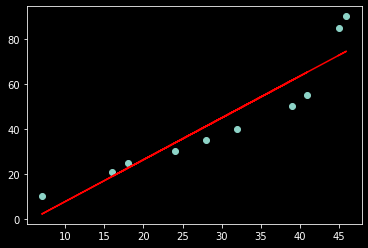

In [42]:
plt.scatter(x = rlm.matriz['x'], y = rlm.matriz['y'])
plt.plot(rlm.matriz['x'], rlm.matriz['yhat'], color = 'red')

R² - O **coeficiênte de ajuste R²** é um um coefiênte que descrever o quanto sua variável $Y_{i}$ é explicada pelo comportamento da suas variávels explicativas.
O R² pode variar entre 0 e 1, onde 1 seria uma correlação linear dos dados perfeita, tento então um modelo que passar perfeitamente por todos os pontos (uma correlação linear perfeita).

SQR - Soma dos quadrados da regressão
SQT - Soma total dos quadrados
SQU - Soma dos quadrados dos resíduos


$$R² = \frac{SQR}{SQR + SQU}$$

ou

$$R² = \frac{\sum\limits _{i=1}^{n} (\hat{Y_{i}} - \overline{Y})}{\sum\limits _{i = 1}^{n}(\hat{Y_{i}} - \overline{Y})^{2} + \sum\limits _{i = 1}^{n}(u_{i})^{2}}$$

In [132]:
data_x = data['Distância (X)']
data_y = data['Tempo (Y)']

figura = go.Figure()

figura.add_trace(go.Scatter(
    x = data_x,
    y = data_y,
    mode = 'markers',
    name = 'Y'
))

figura.add_trace(go.Scatter(
                            x = data_x, 
                            y = rlm.matriz['yhat'],
                            mode='lines',
                            name = 'Yhat'
                            )
                )

media = [rlm.matriz['yhat'].mean() for c in range(rlm.count)]

figura.add_trace(
    go.Line(
        x = data_x,
        y = media,
        name = 'Média'
    )
)

xVals = figura.data[0]['x']
errors = {}

for d in figura.data:
    errors[d['mode']] = d['y']

shapes = []

for i, x in enumerate(figura.data[0]['x']):
    shapes.append(go.layout.Shape(type = 'line',
                                    x0 = x,
                                    y0 = errors['markers'][i],
                                    x1 = x,
                                    y1 = errors['lines'][i],
                                    line = dict(color = 'black', width = 1),
                                    opacity = 1.0,
                                    layer = 'above'

                                )
                            )


for i, x in enumerate(figura.data[0]['x']):
    shapes.append(go.layout.Shape(type = 'line',
                                x0 = x,
                                y0 = errors['markers'][i],
                                x1 = x,
                                y1 = errors[None][i],
                                line = dict(color = 'yellow', width = 1),
                                opacity = 0.5,
                                layer = 'above'
                                
    ))


figura.update_layout(shapes = shapes)
figura.update_yaxes(title = 'Tempo')
figura.update_xaxes(title = 'Distância')
figura.show()

print(rlm.rSquared())

0.868764922010842
